In [1]:
import psycopg2
from sqlalchemy import create_engine, Column, Integer, String, Float, ForeignKey
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy.orm import relationship, sessionmaker
import re
from __future__ import print_function

In [3]:
import numpy as np
import pandas as pd
import nltk
import re
import os
import codecs
from sklearn import feature_extraction
import mpld3
import pandas as pd
from nltk.stem.snowball import SnowballStemmer
#import tensorflow as tf

In [4]:
dbname = 'restaurants'
username = 'andylane'
engine = create_engine('postgres://%s@localhost/%s'%(username,dbname))
print(engine.url)
con = None
con = psycopg2.connect(database = "restaurants", user = "andylane")
Session = sessionmaker(bind=engine)
session = Session()

postgres://andylane@localhost/restaurants


In [5]:
from menusights_aux import *

In [6]:
recipes = pd.read_sql("recipes", engine)

In [7]:
names = session.query(Recipe)

## Get recipe names into a vector

In [8]:
stopwords = nltk.corpus.stopwords.words('english')
stemmer = SnowballStemmer("english")

In [9]:
def tokenize_and_stem(title, is_ingredient = False):
    stemmer = SnowballStemmer("english")
    stemmed_titles = []
    new_title=[]
    for word in nltk.word_tokenize(title):
        new_title.append(stemmer.stem(word))
    stemmed_titles.extend(new_title)
    return " ".join([i for i in stemmed_titles])

In [10]:
def clean_up_ingredient(ingredient_line):
    ingredient_line = re.sub("\[u\'", "", ingredient_line)
    ingredient_line = re.sub("\']", "", ingredient_line)
    return find_measurement_words(ingredient_line)

In [11]:
def get_ingredientslist_for_recipeid(i):
    return [clean_up_ingredient(item.ingredient)\
            for item in names.filter(Recipe.id == i).all()[0].ingredients]

In [12]:
def make_ingredient_list_string(ingredientdictlist):
    return " ".join((str(j["ingredient"] + "INGREDIENT") for j in ingredientdictlist))

In [13]:
tokenized_ingredients = [tokenize_and_stem(make_ingredient_list_string(get_ingredientslist_for_recipeid(i))) for i in (recipes["id"])]
tokenized_names = [tokenize_and_stem(i) for i in (recipes["name"])]
tokenized_name_ing = zip(tokenized_names, tokenized_ingredients)
tokenized_name_ing = map(lambda a: " ".join(a), tokenized_name_ing)

In [14]:
from sklearn.feature_extraction.text import CountVectorizer

In [15]:
tokenized_names = [tokenize_and_stem(i) for i in (recipes["name"])]

In [16]:
vectorizer = CountVectorizer(ngram_range=(1,3), min_df=0.0003)

In [17]:
a = vectorizer.fit_transform(tokenized_names)

In [18]:
from sklearn.feature_selection import f_regression, mutual_info_regression

In [19]:
def chol_to_percentile(vector, operate_on):
    v = [i for i in vector if i != 0]
    pctvector = []
    pct75 = np.percentile(v, 75)
    pct50 = np.percentile(v, 50)
    pct20 = np.percentile(v, 20)
    print(pct75)
    print(pct50)
    print(pct20)
    for index, i in enumerate(operate_on):
        if i > pct75:
            pctvector.append("vhigh")
        elif i > pct50:
            pctvector.append("high")
        elif i > pct20:
            pctvector.append("med")
        else:
            pctvector.append("low")
    return pctvector

In [20]:
cholcat = chol_to_percentile(recipes["cholesterol"], recipes["cholesterol"])

124.0
81.0
47.0


In [21]:
# produces an array with mutual information (weights?) between individual words/n-grams in recipe names and cholesterol information
mi = mutual_info_regression(a, recipes["cholesterol"])
mi /= np.max(mi)

In [22]:
# len(np.array(tokenized_names)[informative_words])

In [26]:
mi.shape

(3453,)

In [27]:
# Returns indices of columns with MI value greater than e.g. 0.01. Can be used for re
informative_words = np.array([(index) for index, i in enumerate(mi) if i>0.002])
# return word vector array with uninformative words removeds
culled_array = a.toarray()[:,informative_words]

In [28]:
culled_array.shape

(3941, 1721)

In [29]:
import cPickle as pkl

In [30]:
ground_truth_x =[]
ground_truth_y =[]
for item in pkl.load(open("groundtruth.pkl", "rb")):
    ground_truth_x.append(item["item_name"])
    ground_truth_y.append(item["nf_cholesterol"])

In [31]:
for item in pkl.load(open("groundtruth2.pkl", "rb")):
        ground_truth_x.append(item["item_name"])
        ground_truth_y.append(item["nf_cholesterol"])

In [32]:
for item in pkl.load(open("groundtruth3.pkl", "rb")):
        ground_truth_x.append(item["item_name"])
        ground_truth_y.append(item["nf_cholesterol"])


In [33]:
tokenized_names_ground_truth = [tokenize_and_stem(i) for i in (ground_truth_x)]
# Puts words from new ground truth set into matrix from training set
ground_truth_vectorized = vectorizer.transform(tokenized_names_ground_truth)
ground_truth_vectorized_culled_array = ground_truth_vectorized.toarray()[:,informative_words]

In [34]:
from collections import Counter

In [35]:
y = np.array(cholcat)

In [36]:
X = culled_array

In [37]:
import numpy as np
def balanced_sample_maker(X, y, sample_size, random_seed=None):
    """ return a balanced data set by sampling all classes with sample_size 
        current version is developed on assumption that the positive
        class is the minority.

    Parameters:
    ===========
    X: {numpy.ndarrray}
    y: {numpy.ndarray}
    """
#     uniq_levels = np.unique(y)
#     uniq_counts = {level: sum(y == level) for level in uniq_levels}
    uniq_levels = list(Counter(y).keys())
    uniq_counts = list(Counter(y).values())
    
    if not random_seed is None:
        np.random.seed(random_seed)

    # find observation index of each class levels
    groupby_levels = {}
    for ii, level in enumerate(uniq_levels):
        obs_idx = [idx for idx, val in enumerate(y) if val == level]
        groupby_levels[level] = obs_idx
    #print(groupby_levels)
    # oversampling on observations of each label
    balanced_copy_idx = []
    for gb_level, gb_idx in groupby_levels.iteritems():
        over_sample_idx = np.random.choice(gb_idx, size=sample_size, replace=True).tolist()
        balanced_copy_idx+=over_sample_idx
    np.random.shuffle(balanced_copy_idx)
    #print(balanced_copy_idx)
    return (X[balanced_copy_idx, :], y[balanced_copy_idx], balanced_copy_idx)

In [38]:
ground_truth_y_cat = chol_to_percentile(recipes["cholesterol"], ground_truth_y)

124.0
81.0
47.0


In [39]:
len(ground_truth_y_cat)

595

In [40]:
ground_truth_vectorized_culled_array.shape

(595, 1721)

In [41]:
ab = balanced_sample_maker(np.array(ground_truth_vectorized_culled_array), np.array(ground_truth_y_cat), 25, random_seed=None)

In [42]:
# for index, i in enumerate(ab[1]):
#     if i == None:
#         ground_truth_y_cat[index] = 0

In [43]:
mask = [index for (index, item) in enumerate(ground_truth_y) if item !=0 or item!=None ]

In [44]:
masked_ground_truth = []
for i,j in enumerate(ground_truth_y):
    if i in mask:
        masked_ground_truth.append(j)
        
masked_ground_truth_vectnames = []
for i,j in enumerate(ground_truth_vectorized_culled_array):
    if i in mask:
        masked_ground_truth_vectnames.append(j)


### A bunch of models

In [45]:
print(__doc__)

import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

X_train = culled_array[:-200]
#y_train = recipes["cholesterol"]
y_train = cholcat[:-200]
X=X_train
y=y_train

clf1 = LogisticRegression(random_state=123, penalty="l2", C=10, solver="lbfgs")
clf2 = RandomForestClassifier(random_state=123)
clf3 = GaussianNB()

probas = [c.fit(X, y) for c in (clf1, clf2, clf3)]

# # get class probabilities for the first sample in the dataset
# class1_1 = [pr[0, 0] for pr in probas]
# class2_1 = [pr[0, 1] for pr in probas]

Automatically created module for IPython interactive environment


In [46]:
X_test = culled_array[-200:]
y_test = cholcat[-200:]

In [47]:
culled_array.shape

(3941, 1721)

In [48]:
from scipy.sparse import csr_matrix

In [49]:
csr_matrix(ground_truth_vectorized_culled_array[2])

<1x1721 sparse matrix of type '<type 'numpy.int64'>'
	with 3 stored elements in Compressed Sparse Row format>

In [50]:
goodindices = list(ab[1][j] for j in [index for index, i in enumerate(ab[0]) if csr_matrix(i).nnz>0])

In [51]:
ground_truth_y_z = [x if x != None else 0 for x in ground_truth_y]

In [52]:
len(ground_truth_y)

595

In [53]:
ab[0].shape

(100, 1721)

In [54]:
ground_truth_vectorized_culled_array.shape

(595, 1721)

In [55]:
ground_truth_vectorized_culled_array

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [56]:
ab[0]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [57]:
ab[0] = ab[0][:,informative_words]

IndexError: index 1727 is out of bounds for axis 1 with size 1721

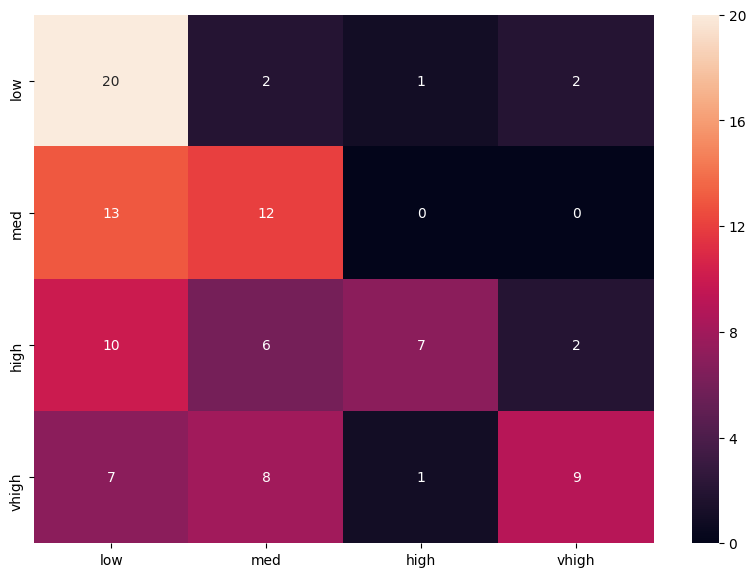

In [58]:
%matplotlib inline
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(ab[1], \
                      clf1.predict(ab[0]), labels=np.array(["low", "med", "high", "vhigh"]))

plt.figure(figsize = (10,7))
sns.heatmap(cm, annot=True, xticklabels=["low", "med", "high", "vhigh"], yticklabels=["low", "med", "high", "vhigh"])

In [59]:
#Just with nnz >0:
%matplotlib inline
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(goodindices, \
                      [clf1.predict(i)[0] for i in ab[0] if csr_matrix(i).nnz>0], labels=np.array(["low", "med", "high", "vhigh"]))
0
plt.figure(figsize = (10,7))
sns.heatmap(cm, annot=True, xticklabels=["low", "med", "high", "vhigh"], yticklabels=["low", "med", "high", "vhigh"])

ValueError: Expected 2D array, got 1D array instead:
array=[0 0 0 ..., 0 0 0].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [60]:
goodindices

['high',
 'med',
 'med',
 'low',
 'low',
 'med',
 'med',
 'low',
 'vhigh',
 'vhigh',
 'med',
 'vhigh',
 'low',
 'med',
 'vhigh',
 'med',
 'vhigh',
 'vhigh',
 'vhigh',
 'vhigh',
 'low',
 'high',
 'med',
 'low',
 'high',
 'high',
 'med',
 'med',
 'high',
 'med',
 'med',
 'low',
 'high',
 'vhigh',
 'med',
 'med',
 'vhigh',
 'vhigh',
 'med',
 'med',
 'low',
 'med',
 'vhigh',
 'vhigh',
 'low',
 'med',
 'vhigh',
 'med',
 'med',
 'vhigh',
 'vhigh',
 'low',
 'vhigh',
 'vhigh',
 'med',
 'low',
 'high',
 'high',
 'med',
 'vhigh',
 'high',
 'high',
 'low',
 'high',
 'med',
 'med',
 'med',
 'high',
 'high',
 'high',
 'high',
 'low',
 'low',
 'low',
 'low',
 'high',
 'vhigh',
 'vhigh']

In [61]:
np.array([i for i in ab[0] if csr_matrix(i).nnz>0])

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [63]:
clf1.score(np.array([i for i in ab[0] if csr_matrix(i).nnz>0]), goodindices)

0.5

In [64]:
cm2 = np.array(cm[:,1])

In [66]:
cm2

array([ 2, 12,  6,  8])

In [67]:
ground_truth_vectorized[2].nnz #get the number of non-zero columns

3

In [68]:
clf1.score(ab[0], ab[1])

0.47999999999999998

In [69]:
ground_truth_vectorized

<595x3453 sparse matrix of type '<type 'numpy.int64'>'
	with 1258 stored elements in Compressed Sparse Row format>

In [70]:
import cPickle as pickle

In [71]:
#pickle.dump(clf1, open("logress.pkl", "wb"))

In [72]:
import os

In [73]:
def report_score_and_why(menuitem, vectorizer=vectorizer, model=clf1):
    input_vectorized = vectorizer.transform([tokenize_and_stem(menuitem)])
    if input_vectorized.nnz > 0:
        print(tokenize_and_stem(menuitem))
        print(input_vectorized.shape)
        #Need to change this to inputting model
        p = model.predict_proba(input_vectorized)[0]
        q = zip(model.classes_, list(p))
        classification = model.predict(input_vectorized)[0]
        probability = dict(q)[classification]
        # Figure out why: list individual score contribution of each word
        matchwords = [i for i in input_vectorized.todok().keys()] #todok = to dict of keys
        explaindict = {}
        ranklist = []
        for i in matchwords:
            w = vectorizer.get_feature_names()[i[1]] #gets actual word of feature, by matrix index
            coef = zip(model.classes_, model.coef_[:,i[1]])
            ranklist.append((w, dict(coef)["vhigh"]))
            explaindict[w] = dict(coef)
        # Figure out the biggest contributor:
        ranklist = sorted(ranklist, key=lambda a: a[1])
    else:
        classification = "unknown"
        probability = 0
        explaindict = {"unscorable": "yes"}
        ranklist = ["unscorable", "unscorable"]
        
    return classification, probability, explaindict, ranklist[-1][0]

In [74]:
report_score_and_why("Mussels")

mussel
(1, 3453)


ValueError: X has 3453 features per sample; expecting 1721